# Deconstructed Interactive Demo

This is a deconstructed version of the demo that is intended to show a bit more detail about the operation of `prospector`. It runs over the same example data as in the `demo_params.py` parameter file, using a similar model.  However, in this demo the implicit methods of the parameter file are made explicit.

First let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
import h5py
import numpy as np
from matplotlib.pyplot import *

%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

**Prospector** utilizes three main packages:
- **fsps**, which governs the fundamental stellar population synthesis models (via the **python-fsps** package),
- **sedpy**, which contains some routines for computing projecting spectra onto filter bandpasses, and
- **prospect**, which is where the likelihood evaluations, parameter priors, and posterior sampling takes place.

Let's import those now.

In [2]:
import fsps
import sedpy
import prospect

# Setup

We need several things to run a fit.  These include 
  1. An `obs` dictionary (with the data we intend to fit)
  2. A stellar population synthesis object (to predict spectra from parameters)
  3. A `model` object (to store and translate parameters and priors)
  4. A likelihood function
  
It can also useful to collect the meta-parameters contolling how the fit is done in a ``run_params`` dictionary. We will do that as we go along.  We will also encapsulate each step of the setup in a series of `load_x()` functions.

## The data to be fit

The data to be fit is stored in a dictionary that we will call `obs`.
The `obs` dictionary stores the observed fluxes, uncertainties, and information about how those fluxes were measured.
For spectra this means the wavelengths at which the fluxes were measured, while for photometry we must know the filters through which the fluxes were measured.
This information is passed (via the `obs` dictionary) to the model object to specify which data to predict.

The units of the fluxes and uncertainties are assumed to be maggies (i.e Jy/3631).
The wavelength units are assumed to be observed frame vacuum angstroms.

We will create an `obs` dictionary below, with all of the required keys, starting with photometry.
In this example we use a row from Table 2 of Johnson et al. 2013

In [3]:
obs = {}
# Get the sedpy.observate.Filter objects that correspond to the measured fluxes and can be used
# First we are going to put together some filter names
galex = ['galex_FUV', 'galex_NUV']
spitzer = ['spitzer_irac_ch'+n for n in ['1','2','3','4']]
sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
filternames = galex + sdss + spitzer
# Now we instantiate the `Filter()` objects using methods in `sedpy`, 
# and put the resulting list of Filter object in the "filters" key of the obs dictionary
obs["filters"] = sedpy.observate.load_filters(filternames)
print(obs["filters"])

[<class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(spitzer_irac_ch1), <class 'sedpy.observate.Filter'>(spitzer_irac_ch2), <class 'sedpy.observate.Filter'>(spitzer_irac_ch3), <class 'sedpy.observate.Filter'>(spitzer_irac_ch4)]


In [4]:
# Now we store the measured fluxes for a single object, **in the same order as "filters"**
# In this example we use a row of absolute AB magnitudes from Johnson et al. 2013
# The units of the fluxes need to be maggies
dm = 30.0  # for 10Mpc distance
M_AB = np.array([-11.93, -12.37, -13.37, -14.22, -14.61, -14.86, 
                 -14.94, -14.09, -13.62, -13.23, -12.78])
mags = M_AB + dm
obs["maggies"] = 10**(-0.4*mags)
# We are going to assume here that the uncertainties are 10%
# In practice you should use real uncertainty estimates if you have them.
# Prospector does contain features that allow you to *fit* for some noise parameters,
# but we will not explore those here.
snr = 10.0
obs["maggies_unc"] = (1./snr) * obs["maggies"]
# Now we use a boolean mask to choose which filters to actually fit
# In this example we mask the spitzer filters.  This means that they aren't 
# included in the fit, but predictions for the spitzer bands are still made
obs["phot_mask"] = np.array(['spitzer' not in f.name for f in obs["filters"]])
# we will also create a handy vector of effective wavelengths, though this is not required
obs["phot_wave"] = [f.wave_effective for f in obs["filters"]]

#Now let's see what the `obs` dictionary looks like
print(obs.keys())
# print(obs)

['phot_wave', 'phot_mask', 'maggies', 'filters', 'maggies_unc']


Now we need to add keys describing the spectra.  In this example we don't have a spectrum, so we just need to do the following:

In [5]:
obs["wavelength"] = None  # this would be a vector of wavelengths in angstroms if we had 
obs["spectrum"] = None
obs['unc'] = None  #spectral uncertainties are given here
obs['mask'] = None

Finally, just to make sure everything is in the right format, we will run it through a little method that makes sure all the required keys are there (adding default values if necessary) and that can make some standard transformations of the data if requested (usually not advisable)

In [6]:
from prospect.utils.obsutils import fix_obs
obs = fix_obs(obs)
print(obs.keys())

['phot_mask', 'phot_wave', 'ndof', 'mask', 'spectrum', 'maggies_unc', 'filternames', 'unc', 'maggies', 'filters', 'wavelength', 'logify_spectrum']


You can see the help for `fix_obs()` to look at the available options for this method.

### The `load_obs` function 
It can be helpful to encapsulate all the logic for reading from your catalog into a single `load_obs` method.  Let's do that now.

In [7]:
def load_obs(snr=10, ldist=10.0, **extras):
    galex = ['galex_FUV', 'galex_NUV']
    spitzer = ['spitzer_irac_ch'+n for n in ['1','2','3','4']]
    sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
    filternames = galex + sdss + spitzer
    
    # Here you could, e.g. read from a catalog
    M_AB = np.array([-11.93, -12.37, -13.37, -14.22, -14.61, -14.86, 
                     -14.94, -14.09, -13.62, -13.23, -12.78])
    dm = 25 + 5.0 * np.log10(ldist)
    mags = M_AB + dm

    obs = {}
    obs["filters"] = sedpy.observate.load_filters(filternames)
    obs["maggies"] = 10**(-0.4*mags)
    obs["maggies_unc"] = (1./snr) * obs["maggies"]
    obs["phot_mask"] = np.array(['spitzer' not in f.name for f in obs["filters"]])
    obs["phot_wave"] = [f.wave_effective for f in obs["filters"]]
    obs["wavelength"] = None  # this would be a vector of wavelengths in angstroms if we had 
    obs["spectrum"] = None
    obs['unc'] = None  #spectral uncertainties are given here
    obs['mask'] = None

    return obs

And we will store some meta-parameters that control the input arguments to this method:

In [8]:
run_params = {}
run_params["snr"] = 10.0
run_params["ldist"] = 10.0

## The model object

Now we need a set of model parameters, which will **define** the model we are tying to fit to the data.  The model object stores the parameters that are used by the SPS object to build a spectrum, as well as infomation about which parameters are to be varied during fitting, and priors on those parameters.  It efficiently converts between a vector of parameter values (the `theta` attribute) used by the MCMC samplers or optimizers and the dictionary of parameter names and values (the `params` attribute) that can be passed to the sps objects' `get_spectrum()` method.

To create the model object we need a list or dictionary of model parameters and some infomation about them.  Each parameter must a have a name, a length (vector parameters are possible), an initial value, and must be specified as either a free parameter or a fixed parameter.  If it is a free parameter it needs a prior as well, which we will get from the `priors` module.

### Building by hand
Let's start by creating a dictionary that describes a single parameter controlling the stellar mass.

In [9]:
from prospect.models import priors
mass_param = {"name": "mass",
              # The mass parameter here is a scalar, so it has N=1
              "N": 1,
              # We will be fitting for the mass, so it is a free parameter
              "isfree": True,
              # This is the initial value. For fixed parameters this is the
              # value that will be used always. 
              "init": 1e8,
              # This sets the prior probability for the parameter
              "prior": priors.LogUniform(mini=1e6, maxi=1e12),
              # this sets the initial dispersion to use when generating 
              # clouds of emcee "walkers".  It is not required, but can be very helpful.
              "init_disp": 1e6, 
              # this sets the minimum dispersion to use when generating 
              #clouds of emcee "walkers".  It is not required, but can be useful if 
              # burn-in rounds leave the walker distribution too narrow for some reason.
              "disp_floor": 1e6, 
              # This is not required, but can be helpful
              "units": "solar masses formed",
              }

Ok, that's the description for one parameter.  Let's **build up the rest of our model** as a dictionary of these parameter descriptions.  At a minimum we will need some sort of distance or redshift information (which in this example is a fixed parameter), and something descibing the SFH.  We could also add parameters controlling metallicity, dust attenuation and emission, nebular emission, even the IMF. Note that any parameter whose value is not explicitly specified via a model parameter dictionary will be given the default value from python-FSPS.

The easiest way to build up this model is to start with some predefined parameter sets from the `prospect.models.templates` module. First, lets look at what pre-packaged parameter sets are available.

In [10]:
from prospect.models.templates import TemplateLibrary

# Look at all the prepackaged parameter sets
TemplateLibrary.show_contents()

'type_defaults':
  Explicitly sets dust amd IMF types.
'agn':
  The set of (fixed) AGN dusty torus emission parameters.
'dirichlet_sfh':
  Non-parameteric SFH with Dirichlet prior
'burst_sfh':
  The set of (fixed) parameters for an SF burst added to a parameteric SFH, with the burst time controlled by `fage_burst`.
'ssp':
  Basic set of (free) parameters for a delta function SFH
'spectral_smoothing':
  Set of parameters for spectal smoothing.
'nebular':
  The set of nebular emission parameters, with gas_logz tied to stellar logzsol.
'dust_emission':
  The set of (fixed) dust emission parameters.
'optimize_speccal':
  Set of parameters (most of which are fixed) for optimizing a polynomial calibration vector.
'parametric_sfh':
  Basic set of (free) parameters for a delay-tau SFH.
'alpha':
  The prospector-alpha model, Leja et al. 2017
'fit_speccal':
  Set of parameters (most of which are free) for sampling the coefficients of a polynomial calibration vector.


It looks like the `"parametric_sfh"` parameter set will do most of what we want.  Let's look at it in more detail.

In [11]:
TemplateLibrary.describe("parametric_sfh")

Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1e+12)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  imf_type: 2 
  dust_type: 0 
  zred: 0.1 
  sfh: 4 


That looks pretty good.  We'll just adjust a couple of the initial values and priors, and add a parameter that will set the distance even though the redshift of theses objects is zero.

In [12]:
# Get (a copy of) one of the prepackaged model set dictionaries
model_dict = TemplateLibrary["parametric_sfh"]

# Now add the lumdist parameter.  This will control the distance since we are setting the redshift to zero.  
# In `load_obs` above we used a distance of 10Mpc to convert from absolute to apparent magnitudes, 
# so we use that here too, since the `maggies` are appropriate for that distance.
model_dict["lumdist"] = {"N": 1, "isfree": False, "init": 10.0, "units":"Mpc"}

# And make some other changes to initial values
model_dict["zred"]["init"] = 0.0
model_dict["dust2"]["init"] = 0.0
model_dict["tage"]["init"] = 10.0
model_dict["logzsol"]["init"] = -0.3

# These are dwarf galaxies, so lets adjust the metallicity prior,
# the tau parameter upward, and the mass prior downward
model_dict["logzsol"]["prior"] = priors.TopHat(mini=-1.5, maxi=0.1)
model_dict["tau"]["prior"] = priors.LogUniform(mini=1e-1, maxi=1e2)
model_dict["mass"]["init"] = 1e8
model_dict["mass"]["prior"] = priors.LogUniform(mini=1e6, maxi=1e10)

# If we are going to be using emcee, it is useful to provide a 
# minimum scale for the cloud of walkers (the default is 0.1)
model_dict["mass"]["init_disp"] = 1e7
model_dict["tau"]["init_disp"] = 1.0
model_dict["tage"]["init_disp"] = 1.0

# Now instantiate the model using this dictionary of parameter specifications
from prospect.models import SedModel
model = SedModel(model_dict)
print("Fixed parameters: {}".format(model.fixed_params))
print("Free parameters: {}".format(model.free_params))
print("Initial free parameter vector theta:\n {}".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

Fixed parameters: ['zred', 'dust_type', 'lumdist', 'imf_type', 'sfh']
Free parameters: ['logzsol', 'dust2', 'tau', 'tage', 'mass']
Initial free parameter vector theta:
 [-3.e-01  0.e+00  1.e+00  1.e+01  1.e+08]
Initial parameter dictionary:
{'logzsol': array([-0.3]), 'dust2': array([0.]), 'imf_type': array([2]), 'tau': array([1]), 'dust_type': array([0]), 'lumdist': array([10.]), 'tage': array([10.]), 'zred': array([0.]), 'mass': array([1.e+08]), 'sfh': array([4])}


### Manipulating the `model` object
Great.  We now have a model.  We're fitting for 5 parameters here:
- stellar mass *formed* $M_\star$,
- metallicity $\log Z/Z_\odot$, 
- age $t$ of the galaxy 
- star formation timescale $\tau$ for an exponentially declining star formation history (SFH), and
- dust attenuation of old stellar populations $A_V$.

Everything else here is fixed explicitly.  There are many other `sps` parameters that are set implicitly in the FSPS defaults.  Note that by default the stellar mass here refers to the stellar mass *formed* by the given age, which will always be slightly higher than the *surviving* stellar mass, due to mass loss during stellar evolution (winds, SNe, etc.)

Let's change some of the parameter values in a couple different ways, and look at the prior probablity for those new parameter combinations.

In [13]:
theta = model.theta.copy()
print("Initial parameters:\n  {}".format(model.theta))
print("Initial ln_prior_probability: {}".format(model.prior_product(theta)))

# let's increase the mass by a factor of 10 by manipulating the copied theta vector
theta[model.theta_index["mass"]] *= 10
print("New ln_prior_probability: {}".format(model.prior_product(theta)))
# note that the new parameter vector does not get propogated into the model object 
# by the prior_product() call
print("Theta after new prior call:\n  {}".format(model.theta))
print("Mass after new prior call: {}".format(model.params["mass"]))
# but we can force that to happen by doing this
model.set_parameters(theta)
print("Theta after set_parameters call:\n  {}".format(model.theta))
print("Mass after set_parameters call: {}".format(model.params["mass"]))

# Now let's increase the mass again by accessing the params dictionary directly 
# (instead of through a separate theta vector.)
# This is the only way to change fixed parameters without reinstantiating or 
# reconfiguring the model object from a new configuration dictionary or list.
model.params["mass"] *= 10
# the change now shows up in the model.theta attribute
print("Theta after params access:\n  {}".format(model.theta)) 
print("Mass after params access: {}".format(model.params["mass"]))
# but the external theta vector did not change
print("External theta vector: {}".format(theta))
# So let's use the model.theta attribute to calculate again the prior probability
print("Final ln_prior_probability: {}".format(model.prior_product(model.theta)))

# reset the mass
model.params["mass"] = 1e8

Initial parameters:
  [-3.e-01  0.e+00  1.e+00  1.e+01  1.e+08]
Initial ln_prior_probability: -26.3613992198
New ln_prior_probability: -28.6639843128
Theta after new prior call:
  [-3.e-01  0.e+00  1.e+00  1.e+01  1.e+08]
Mass after new prior call: [1.e+08]
Theta after set_parameters call:
  [-3.e-01  0.e+00  1.e+00  1.e+01  1.e+09]
Mass after set_parameters call: [1.e+09]
Theta after params access:
  [-3.e-01  0.e+00  1.e+00  1.e+01  1.e+10]
Mass after params access: [1.e+10]
External theta vector: [-3.e-01  0.e+00  1.e+00  1.e+01  1.e+09]
Final ln_prior_probability: -30.9665694058


### The `load_model` function
As for the ``obs`` dictionary and the ``sps`` object it can be sueful to define a ``load_model`` method that instantiates the ``model`` object.  This method can also be used to change the parameter specification dictionaries according to adjustable arguments.  Let's do an example where we change whether the metallicity is a free and fitted parameter or fixed to a particular value, optionally turn on dust emission, and where we can set the redshift by hand as well.

In [14]:
def load_model(object_redshift=None, fixed_metallicity=None, add_dust=False, 
               ldist=10.0, **extras):
    
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary

    model_params = TemplateLibrary["parametric_sfh"]
    
    # Add lumdist parameter
    model_params["lumdist"] = {"N": 1, "isfree": False, "init": ldist, "units":"Mpc"}
    
    # Adjust model initial values
    model_params["zred"]["init"] = 0.0
    model_params["dust2"]["init"] = 0.0
    model_params["logzsol"]["init"] = -0.3
    model_params["tage"]["init"] = 13.
    model_params["mass"]["init"] = 1e8
    
    # adjust priors
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params["tau"]["prior"] = priors.LogUniform(mini=1e-1, maxi=1e2)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e6, maxi=1e10)

    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params["mass"]["disp_floor"] = 1e7
    model_params["tau"]["disp_floor"] = 1.0
    model_params["tage"]["disp_floor"] = 1.0
    
    # Change the model parameter specifications based on some keyword arguments
    if fixed_metallicity is not None:
        # make it a fixed parameter
        model_params["logzsol"]["isfree"] = False
        #And use value supplied by fixed_metallicity keyword
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift

    if add_dust:
        # Add dust emission (with fixed dust SED parameters)
        model_params.update(TemplateLibrary["dust_emission"])
        
    # Now instantiate the model using this new dictionary of parameter specifications
    model = SedModel(model_params)

    return model

run_params["object_redshift"] = 0.0
run_params["fixed_metallicity"] = None
run_params["add_dust"] = True

## The `sps` object
We need an object that will build SEDs for a given set of parameters.  In `prospector` we call these **sps** objects.  Given a dictionary of parameters (provided by the model object), they must be able to return a spectrum, photometry, and maybe some ancillary information.  This is often done using large spectral libraries and, for galaxies, isochrone information.  Typically in `prospector` we use `fsps.StellarPopulation` objects, under thin wrappers that add a little functionality and change the API a bit. The different wrappers correspond to different SFH parameterizations. Here we use `CSPSpecBasis` which works with (linear combinations of) composite stellar populations as described in the FSPS manual with `sfh_type` of 1, 4, or 5.  Other `sps` objects can be used for non-parameteric SFH, notable `prospect.sources.FastStepBasis`.

In [15]:
from prospect.sources import CSPSpecBasis
# zcontinuous = 1 insures that we use interpolation between SSPs to 
# have a continuous metallicity parameter `logzsol` 
# See python-FSPS documentation for details
sps = CSPSpecBasis(zcontinuous=1)

This object often has a large memory footprint, since it contains all the spectral libraries and isochrones.
It has one very important method, `get_spectrum()`.  Indeed, the only definition of an `sps` object (for example if you want to make your own) is that it have this method.  In typical use, any FSPS parameter can be passed to this method as an extra keyword argument and the model will be built using that parameter.  Several additional parameters controlling, e.g., spectral smoothing or the wavelength calibration can also be passed to the default objects.

In [16]:
help(sps.get_spectrum)

Help on method get_spectrum in module prospect.sources.ssp_basis:

get_spectrum(self, outwave=None, filters=None, peraa=False, **params) method of prospect.sources.galaxy_basis.CSPSpecBasis instance
    Get a spectrum and SED for the given params.
    
    :param outwave: (default: None)
        Desired *vacuum* wavelengths.  Defaults to the values in
        `sps.wavelength`.
    
    :param peraa: (default: False)
        If `True`, return the spectrum in erg/s/cm^2/AA instead of AB
        maggies.
    
    :param filters: (default: None)
        A list of filter objects for which you'd like photometry to be calculated. 
    
    :param **params:
        Optional keywords giving parameter values that will be used to
        generate the predicted spectrum.
    
    :returns spec:
        Observed frame spectrum in AB maggies, unless `peraa=True` in which
        case the units are erg/s/cm^2/AA.
    
    :returns phot:
        Observed frame photometry in AB maggies.
    
    :retur

### The `load_sps` function
Again, it can be helpful to encapsulate the loading of the sps object in a `load_sps` method, with meta-parameters controlling the how the object is instantiated

In [17]:
def load_sps(zcontinuous=1, **extras):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1

### View the model
Now that we have the `sps` object we can also generate a prediction for the data from any set of model parameters.  To see how this works, lets make an SED!

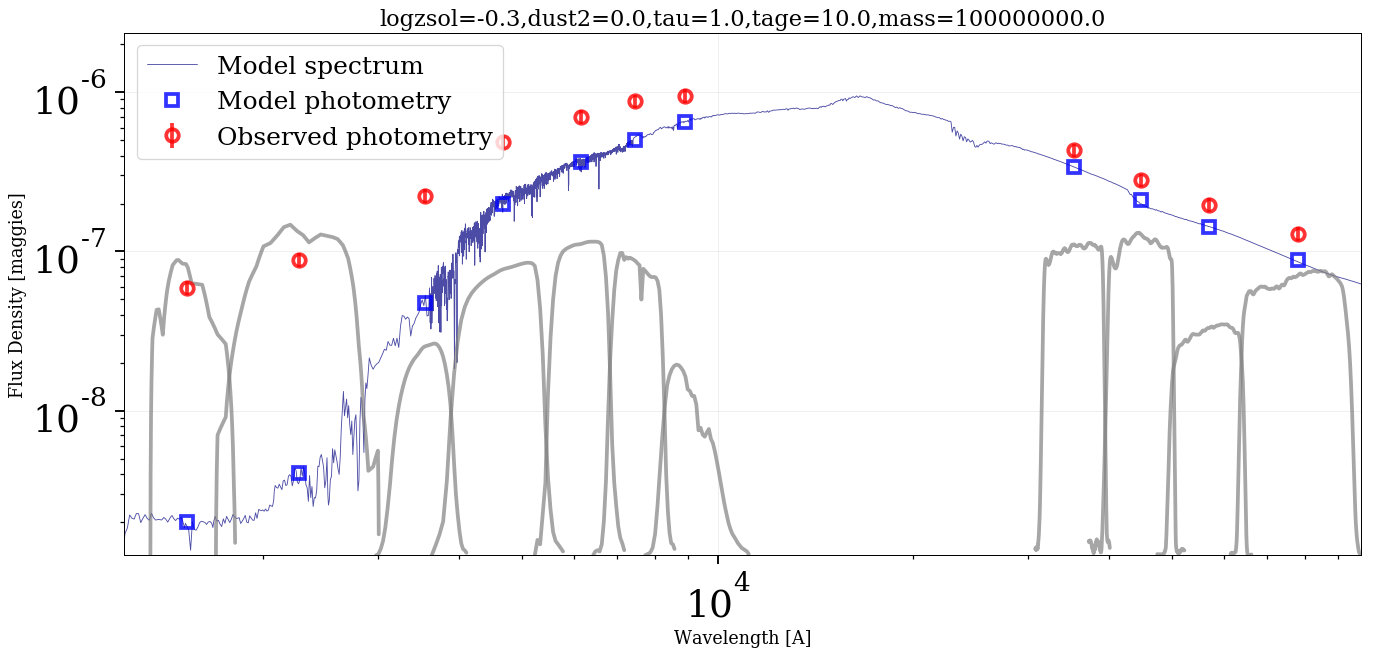

In [18]:
# Generate the model SED at some value of theta
theta = model.theta.copy()
theta[model.theta_index["mass"]] = 1e8
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
# spec, phot, x = sps.get_spectrum(outwave=obs['wavelength'], filters=obs["filters"], **model.params)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()


Note that creating a new model with FSPS is somewhat time-intensive (of order seconds), but once the relevant SSPs have been built they are subsequently stored in cache so similar models can be generated much more quickly (of order milliseconds, unless you are changing parameters that affect the SSPs, like the IMF)

## Likelihood function
Now all we are missing is a likelihood function.  In most cases, this will simply be a function of the **spectral likelihood** and a **photometric likelihood** such that

$$
\mathcal{L} = f(\mathcal{L}_{\textrm{spec}}, \mathcal{L}_{\textrm{phot}}) \quad .
$$

Assuming our errors are Normal (i.e. Gaussian), the log-likelihoods for each component are extremely straightforward to define and can be imported directly from Prospector.  How we choose to combine these likelihoods might vary depending on the particulars of our data. For the demo, our likelihood function for our model parameters $\boldsymbol{\theta}$ is just

$$
\ln\mathcal{L}(\boldsymbol{\theta}) = \ln\mathcal{L}_{\textrm{spec}}(\boldsymbol{\theta}) + \ln\mathcal{L}_{\textrm{phot}}(\boldsymbol{\theta}) \quad .
$$

Below is a simple version of the likelihood function used in `prospector`.  Note that more complicated likelihoods including covariant noise and fitted noise parameters are possible, using special NoiseModel classes within `prospector`.  Also we are using the globally defined `obs`, `model`, and `sps`; in principle these could be passed as arguments to the `lnprobfn`.

For nested sampling `lnprobfn(theta, nested=True)` will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling `lnprobfn(theta, nested=False)` returns the posterior probability.

When using the provided scripts (`prospector.py` and `prospector_nest.py`) you don't have to specify the likelihood function yourself, it is defined in those scripts.

In [19]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

verbose = False
def lnprobfn(theta, nested=False, verbose=verbose):
    """
    Given a parameter vector, a dictionary of observational data 
    a model object, and an sps object, return the ln of the posterior. 
    This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.
    """

    # Calculate prior probability and exit if not within prior
    # Also if doing nested sampling, do not include the basic priors, 
    # since the drawing method includes the prior probability
    lnp_prior = model.prior_product(theta, nested=nested)
    if not np.isfinite(lnp_prior):
        return -np.infty
        
    # Generate "mean" model
    t1 = time.time()
    spec, phot, mfrac = model.mean_model(theta, obs, sps=sps)
    d1 = time.time() - t1
 
    # Calculate likelihoods
    t2 = time.time()
    lnp_spec = lnlike_spec(spec, obs=obs)
    lnp_phot = lnlike_phot(phot, obs=obs)
    d2 = time.time() - t2
    if verbose:
        write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

    return lnp_prior + lnp_phot + lnp_spec

run_params["verbose"] = verbose

It can also be useful for some optimization methods (i.e. Levenberg-Marquardt) to define a function that returns the vector of chi-square residuals.  Let's do that.

In [20]:
from prospect.likelihood import chi_spec, chi_phot
def chivecfn(theta):
    """A version of lnprobfn that returns the simple uncertainty 
    normalized residual instead of the log-posterior, for use with 
    least-squares optimization methods like Levenburg-Marquardt.
    
    It's important to note that the returned chi vector does not 
    include the prior probability.
    """
    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return -np.infty

    # Generate mean model
    t1 = time.time()
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return -np.infty
    d1 = time.time() - t1

    chispec = chi_spec(spec, obs)
    chiphot = chi_phot(phot, obs)
    return np.concatenate([chispec, chiphot])

# Running Prospector
Now that we have defined the model and set up the data that we want to fit, we are ready to run prospector.  We will do this in a few steps.  First we will run all the convenience functions we made earlier to get the fitting ingredients and set up the output.  Then we will conduct a $\chi^2$ minimization. Finally we will run an ensemble MCMC sampler around the best location form the minimization and save the output.

## Preparing
Here we will run all our convenience functions and set up the output file(s) where our results will be saved.

In [21]:
obs = load_obs(**run_params)
sps = load_sps(**run_params)
model = load_model(**run_params)

### Set Up Outputs
We are just about ready to do the inference. But before we start running anything, let's just check whether we can write out our fits to an HDF5 file. If not, we'll just dump them as a pickle at the end.  As the HDF5 output is set up, the `model_params` list, the `obs` dictionary, and the `run_params` dictionary are serialized (if possible) and added as attributes or datasets in the HDF5 file.

In [22]:
from prospect.io import write_results

In [23]:
run_params["outfile"] = 'demo'
outroot = "{0}_{1}".format(run_params['outfile'], int(time.time()))
try:
    hfilename = outroot + '_mcmc.h5'
    hfile = h5py.File(hfilename, "a")
    print("Writing to file {}".format(hfilename))
    write_results.write_h5_header(hfile, run_params, model)
    write_results.write_obs_to_h5(hfile, obs)
except:
    hfile = None

Writing to file demo_1530910901_mcmc.h5
Could not serialize model_params


## Minimization Step
We can attempt to initialize our model reasonably close to the data by using some numerical minimization routines.
Here we will use Levenberg-Marquardt. Keywords that control the optimization algorithm will again be stored in the `run_params` dictionary. Levenberg-Marquardt requires a likelihood function that returns a vector of chi values, not an actual likelihood, so we will write that. It's important to note that in the function below we do *not* account for prior probabilities.

In [24]:
from prospect import fitting
from scipy.optimize import least_squares
run_params["nmin"] = 5
run_params['ftol'] = 3e-16 
run_params['maxfev'] = 5000
run_params['xtol'] = 3e-16

In [25]:
# --- start minimization ----
min_method = 'levenberg_marquardt'
run_params["min_method"] = min_method

# We'll start minimization from "nmin" separate places, 
# the first based on the "init" values of each parameter and the 
# rest drawn from the prior.  This can guard against local minima.
nmin = run_params["nmin"]
ts = time.time()  # time it
pinitial = fitting.minimizer_ball(model.initial_theta.copy(), nmin, model)
guesses = []
for i, pinit in enumerate(pinitial): #loop over initial guesses
    res = least_squares(chivecfn, np.array(pinit), method='lm', x_scale='jac',
                        xtol=run_params["xtol"], ftol=run_params["ftol"], 
                        max_nfev=run_params["maxfev"])
    guesses.append(res)

# Calculate chi-square of the results, and choose the best one
# fitting.reinitialize moves the parameter vector away from edges of the prior.
chisq = [np.sum(r.fun**2) for r in guesses]
best = np.argmin(chisq)
theta_best = fitting.reinitialize(guesses[best].x, model,
                                  edge_trunc=run_params.get('edge_trunc', 0.1))
initial_prob = None
pdur = time.time() - ts

# output results
print('done {0} in {1}s'.format(min_method, pdur))
print('best {0} chi-sq: {1}'.format(min_method, chisq[best]))
print('best guess paramaters:')
for k, t in zip(model.theta_labels(), theta_best):
    print('  {} = {}'.format(k, t))


done levenberg_marquardt in 36.2424008846s
best levenberg_marquardt chi-sq: 1.57899150188
best guess paramaters:
  logzsol = -1.50060233665
  dust2 = 0.73090710455
  tau = 0.898400928884
  tage = 3.4445527331
  mass = 79791353.1792


/usr/local/lib/python2.7/site-packages/prospect-0.2-py2.7.egg/prospect/models/priors.py:154: RuntimeWarning: divide by zero encountered in log


### View model after minimization
Now let's see how our model looks in the data space after minimization.

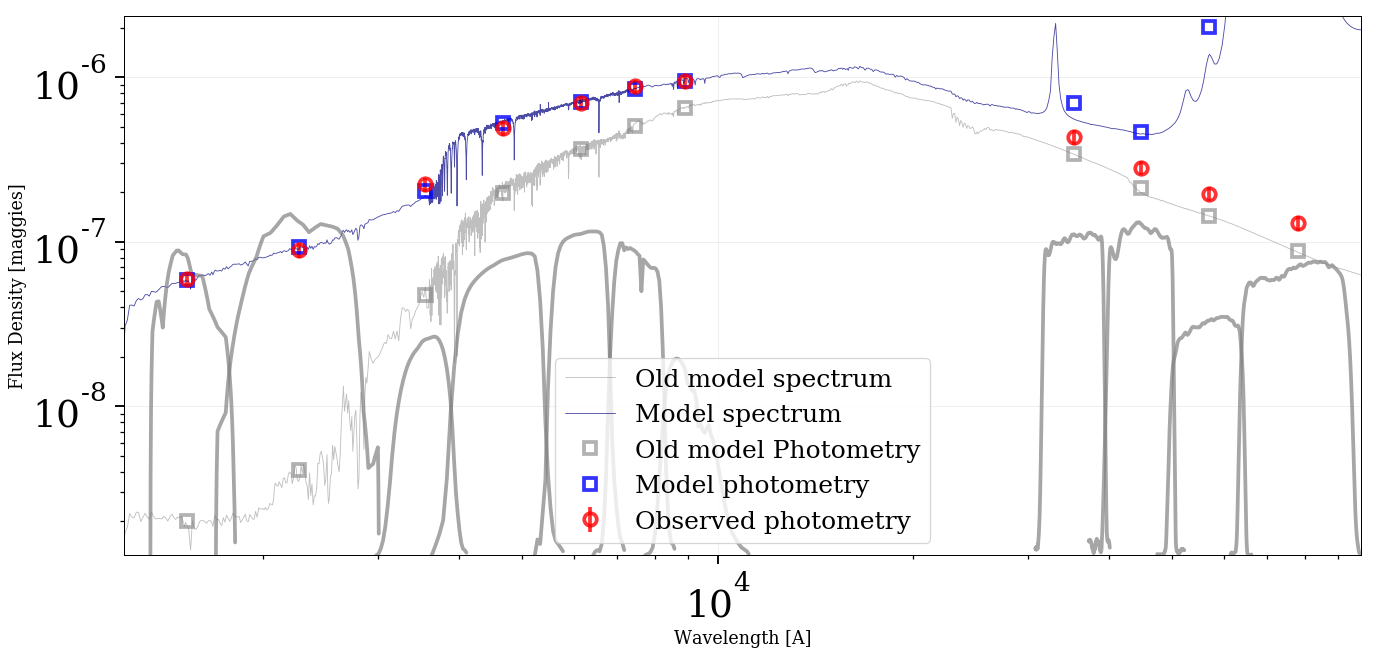

In [26]:
# generate model
prediction = model.mean_model(theta_best, obs, sps=sps)
pspec, pphot, pextra = prediction

figure(figsize=(16,8))

# plot Data, models, and old models
loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

That should look much better, except maybe for the filters that we have masked out.

## Sampling the Posterior
Now that we're somewhat burned in, we can begin sampling from the posterior using **Markov Chain Monte Carlo** (MCMC). Prospector by default uses **emcee**, and will try to parallelize the process over multiple cores when available through MPI and mpi4py. In this interactive notebook though we will assume single-threaded operation. 

The `emcee` algorithm requires several options to be specified, related to the number of walkers, the number of iterations, and to rounds of burn-in.  For convenience we will store these in the `run_params` meta-parameter dictionary that we've been using.

In [27]:
# Number of emcee walkers
run_params["nwalkers"] = 128
# Number of iterations of the MCMC sampling
run_params["niter"] = 512
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]
# The following number controls how often the chain is written to disk. This can be useful 
# to make sure that not all is lost if the code dies during a long MCMC run. It ranges 
# from 0 to 1; the current chains will be written out every `interval` * `niter` iterations.
# The default is 1, i.e. only write out at the end of the run.
run_params["interval"] = 0.25 # write out after every 25% of the sampling is completed.

Let's go ahead and start sampling!

In [28]:
# suppress output
fout = sys.stdout
fnull = open(os.devnull, 'w')
sys.stdout = fnull

# set the initial center of the ball of walkers to the best optimization result
initial_center = theta_best.copy()

# Start sampling
tstart = time.time()  # time it
out = fitting.run_emcee_sampler(lnprobfn, initial_center, model,
                                pool=None, hdf5=hfile, **run_params)
esampler, burn_loc0, burn_prob0 = out
edur = time.time() - tstart

sys.stdout = fout

print('done emcee in {0}s'.format(edur))

done emcee in 492.124147892s


/usr/local/lib/python2.7/site-packages/prospect-0.2-py2.7.egg/prospect/fitting/ensemble.py:358: RuntimeWarning: covariance is not positive-semidefinite.


### Write Output
Now that everything's all set, let's save our results to disk.  These will be written to 2 or 3 files beginning with the value of `outroot`.

In [29]:
write_results.write_hdf5(hfile, run_params, model, obs, 
                         esampler, guesses,
                         toptimize=pdur, tsample=edur,
                         sampling_initial_center=initial_center,
                         post_burnin_center=burn_loc0,
                         post_burnin_prob=burn_prob0)

# The code below can be used to write python pickles (like IDL save files) to disk.  
# These are not necessary, but can be convenient.
#write_results.write_pickles(run_params, model, obs, esampler, guesses,
#                            outroot=outroot, toptimize=pdur, tsample=edur,
#                            sampling_initial_center=initial_center,
#                            post_burnin_center=burn_loc0,
#                            post_burnin_prob=burn_prob0)

print('Finished')

Could not serialize model_params
Finished


# Visualizing the Results

There are a few basic plotting tools available to do a quick check on the results available in *prospect.io.read_results* and *prospect.utils.plotting*. We'll hack a few of these together in *plot_utils* here in the demo folder to make them a bit more amenable to plotting in this notebook.  We'll also import some functions useful for reading the output files we made.

In [30]:
from prospect.io.read_results import results_from, get_sps
from prospect.io.read_results import traceplot, subcorner
print(outroot) # This is the start of the filename where we saved the results

demo_1530910901


## Reading output files
Reading our results from our Pickle or HDF5 file is straightforward using the `results_from` method.  This returns a "results" dictionary, the `obs` dictionary of data to which the model was fit, and the `SedModel` object that was used in the fitting.

In [31]:
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
res, obs, mod = results_from("{}_mcmc.h5".format(outroot), dangerous=False)
# let's look at what's stored in the `res` dictionary
print(res.keys())

[u'initial_theta', 'model', 'optimization_results', u'prospector_version', u'chain', u'theta_labels', u'sampling_duration', u'model_params', u'optimizer_duration', u'acceptance', u'rstate', u'sampling_initial_center', u'run_params', u'lnprobability', u'paramfile_text', 'obs']


## Plotting parameter traces
To see how our MCMC samples look, we can examine a few traces (that is, the evolution of the parameter value with iteration in the MCMC chain.)  You can use these plots (and the chains more generally) to assess whether the MCMC has converged, or if you need to sample for more iterations.

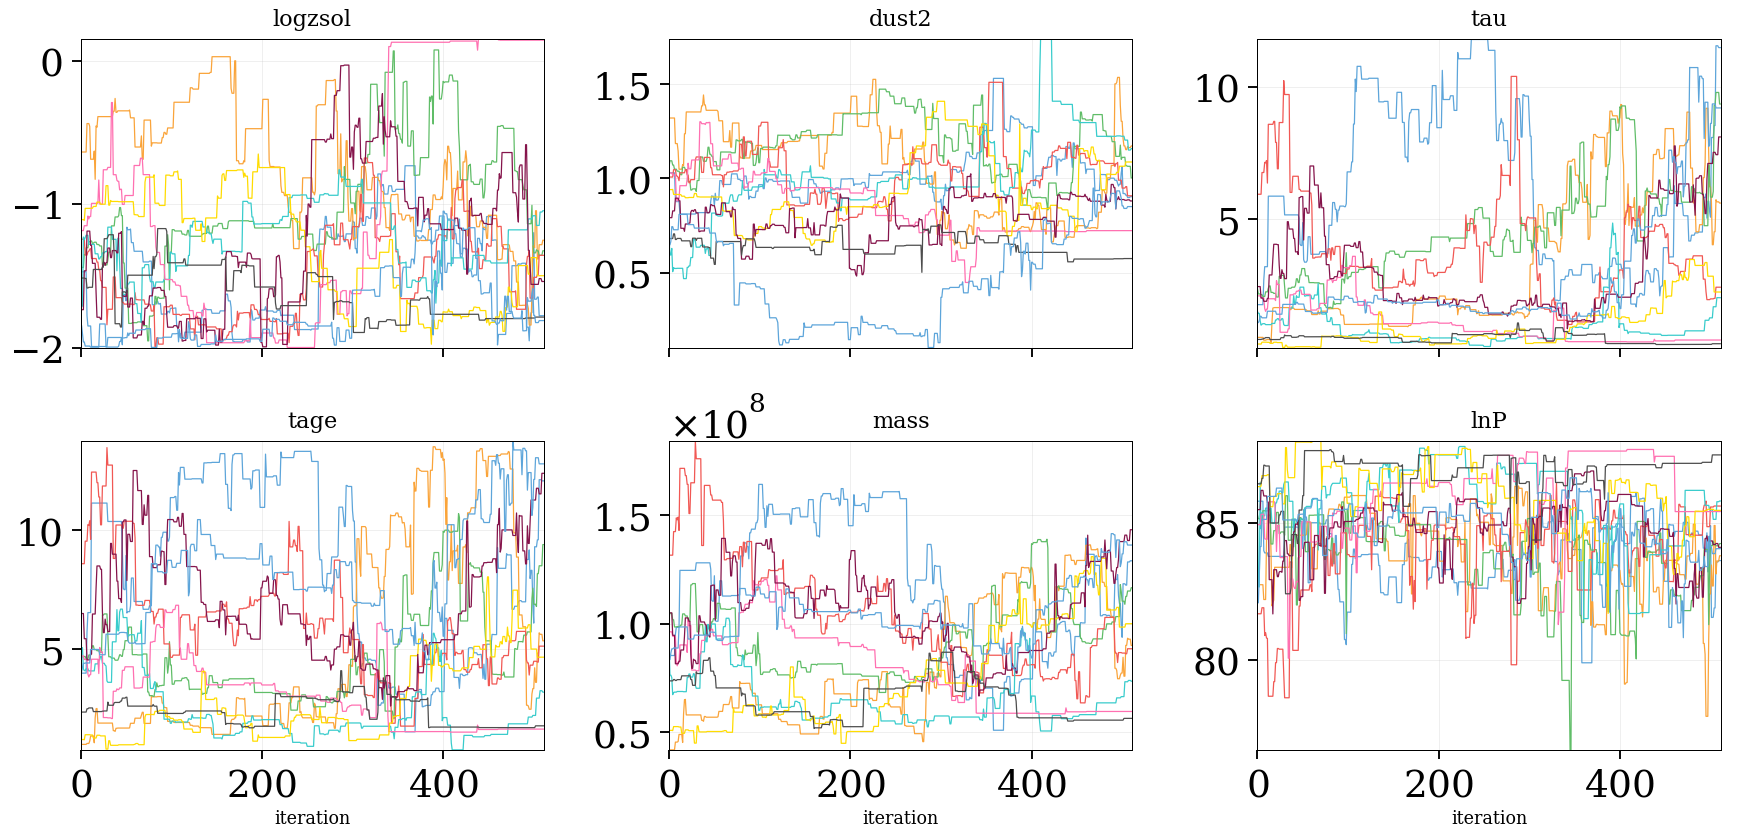

In [32]:
chosen = np.random.choice(run_params["nwalkers"], 
                          size=10, replace=False)
tracefig = traceplot(res, figsize=(20,10), chains=chosen)

## Making a corner plot
Our samples more generally can be shown using a corner/triangle plot.  The `subtriangle()` method below is a very thin wrapper on Dan Foreman-Mackey's **corner.py** code.  We'll overplot the MAP value as blue lines.

Optimization value: [-1.50060234e+00  7.30907105e-01  8.98400929e-01  3.44455273e+00
  7.97913532e+07]
MAP value: [-7.0480466e-01  8.0108237e-01  3.7675229e-01  1.5734991e+00
  5.5312480e+07]


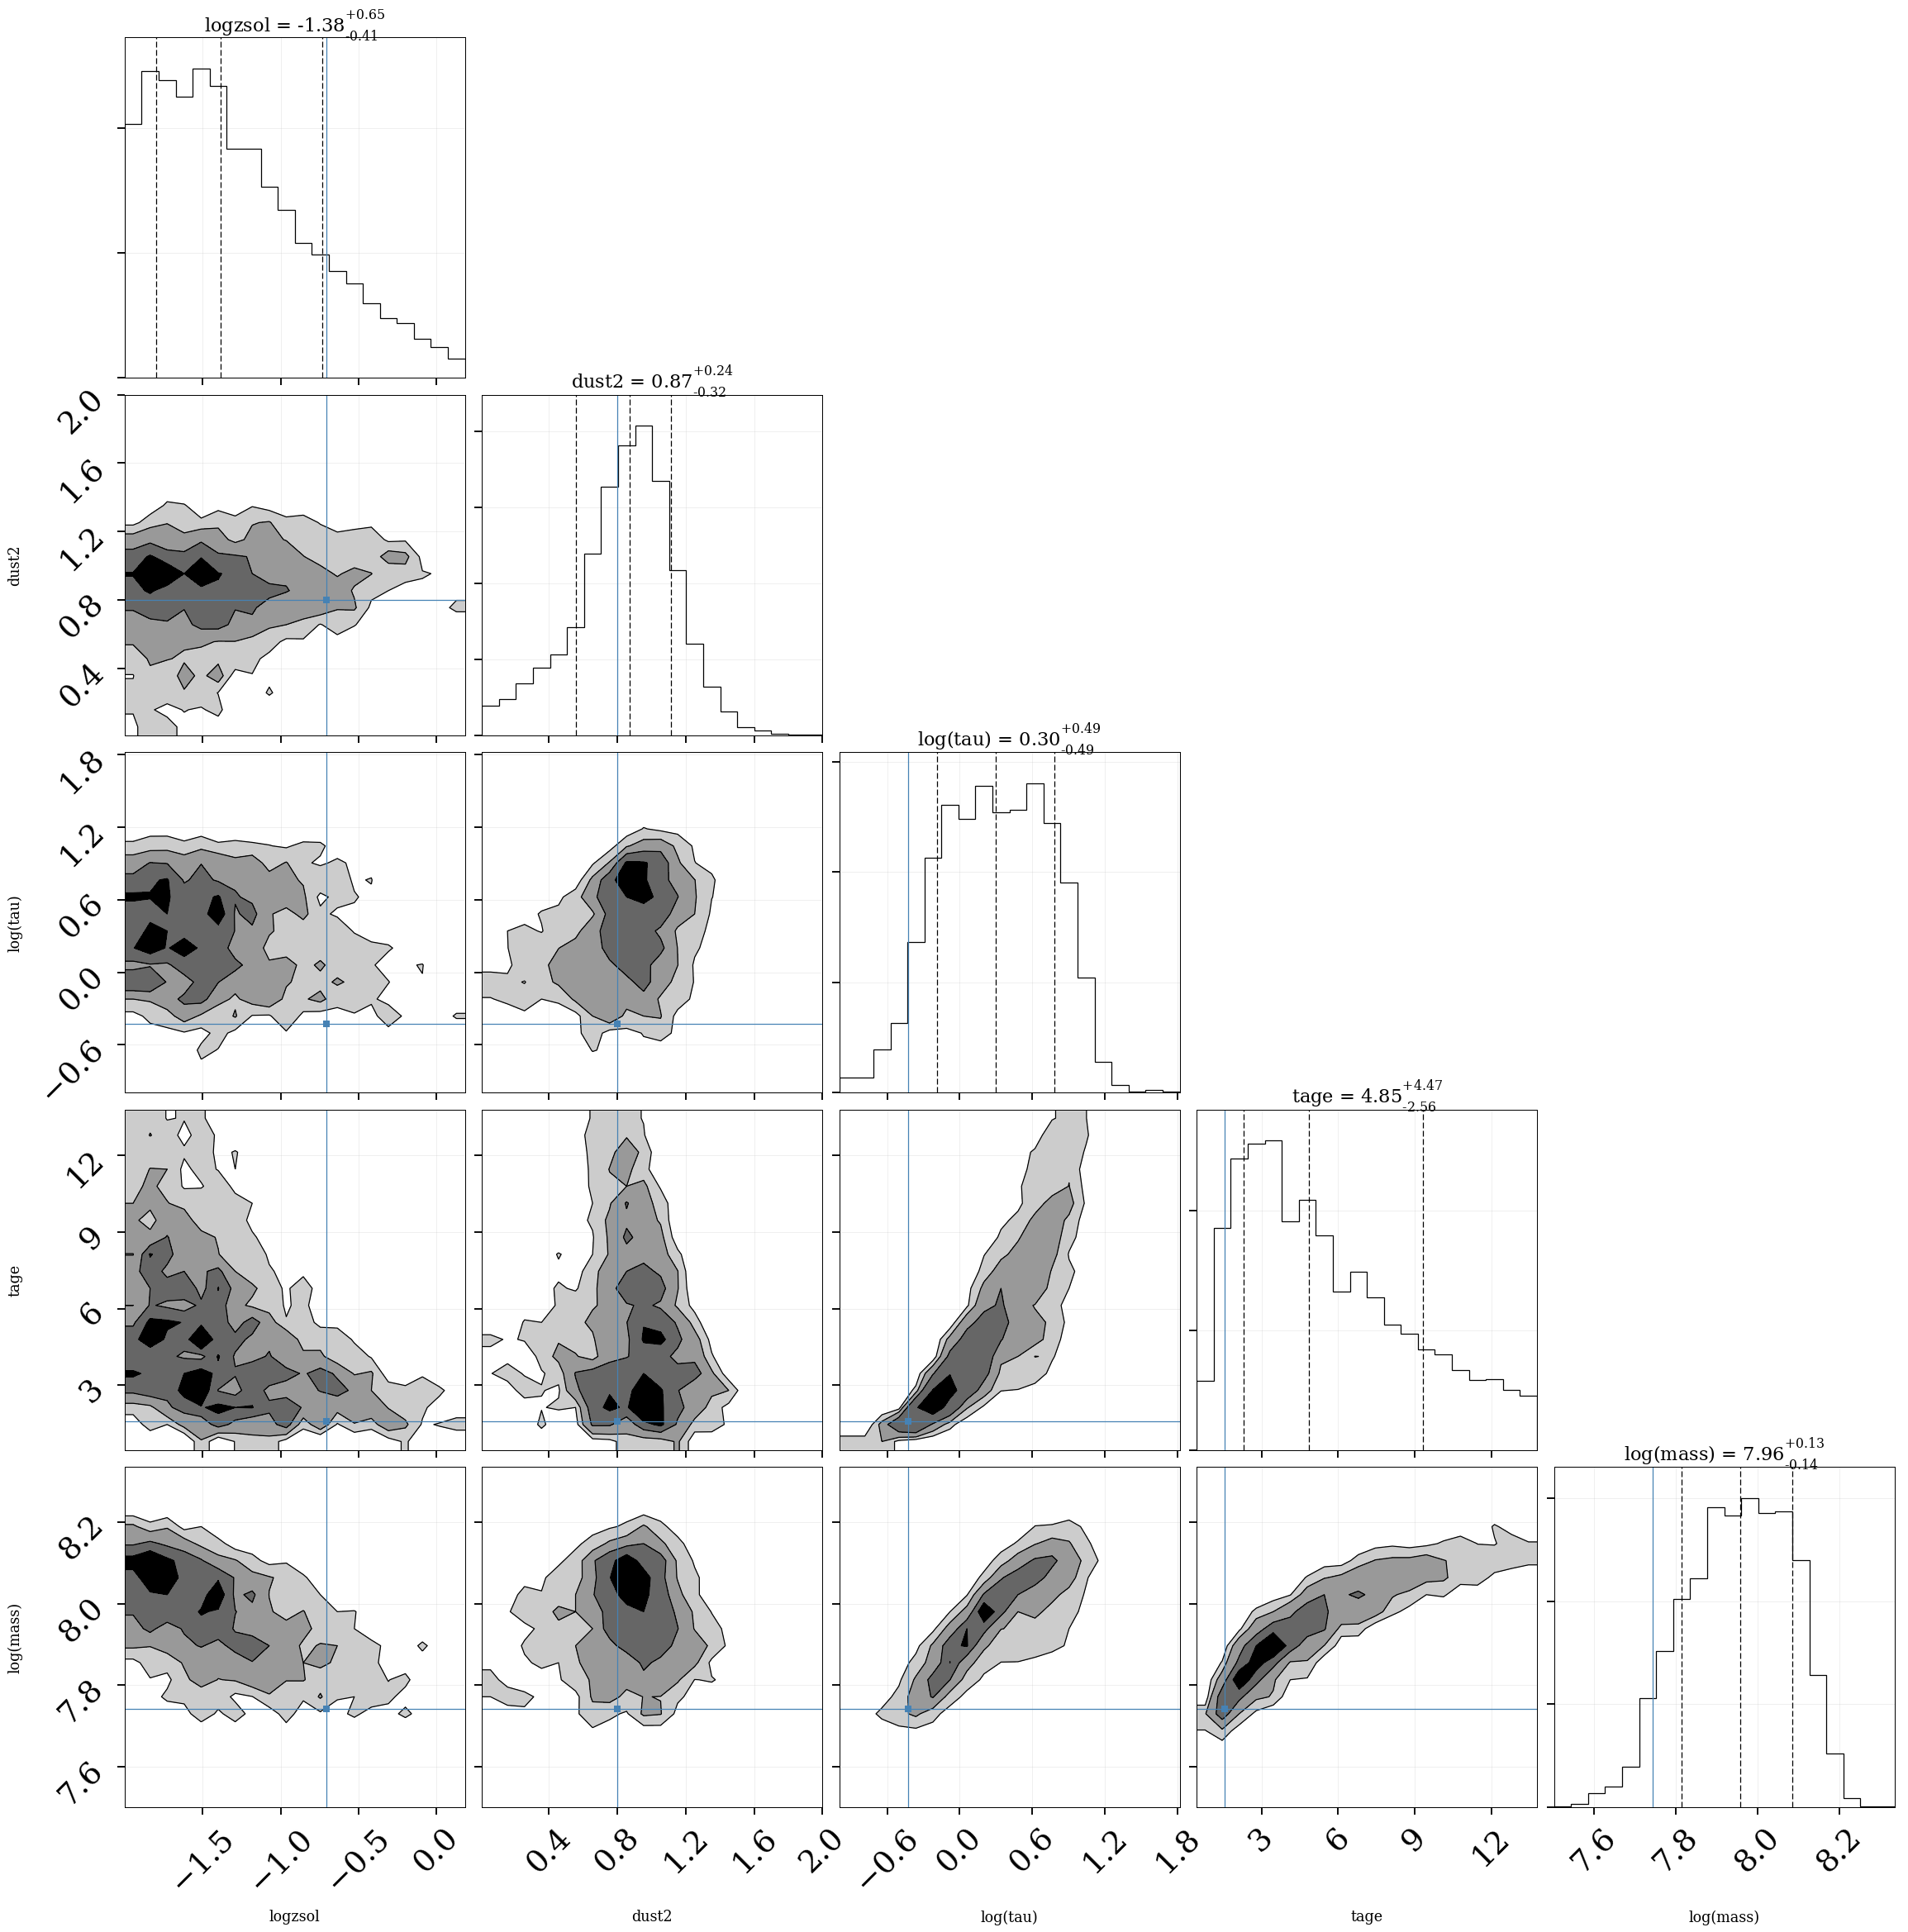

In [33]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(res['lnprobability'])
i, j = np.unravel_index(imax, res['lnprobability'].shape)
theta_max = res['chain'][i, j, :].copy()

print('Optimization value: {}'.format(initial_center))
print('MAP value: {}'.format(theta_max))
cornerfig = subcorner(res, start=0, thin=5, truths=theta_max, 
                      fig=subplots(5,5,figsize=(27,27))[0])

## Look at SEDs and residuals
Finally, let's just take a look at a random model drawn from our chains, and at the highest posterior probability model in the chain.  In this notebook we already have the `sps` object instantiated, but in general we may have to regenerate it based on information stored in the output file using the `prospect.io.read_results.get_sps` method.

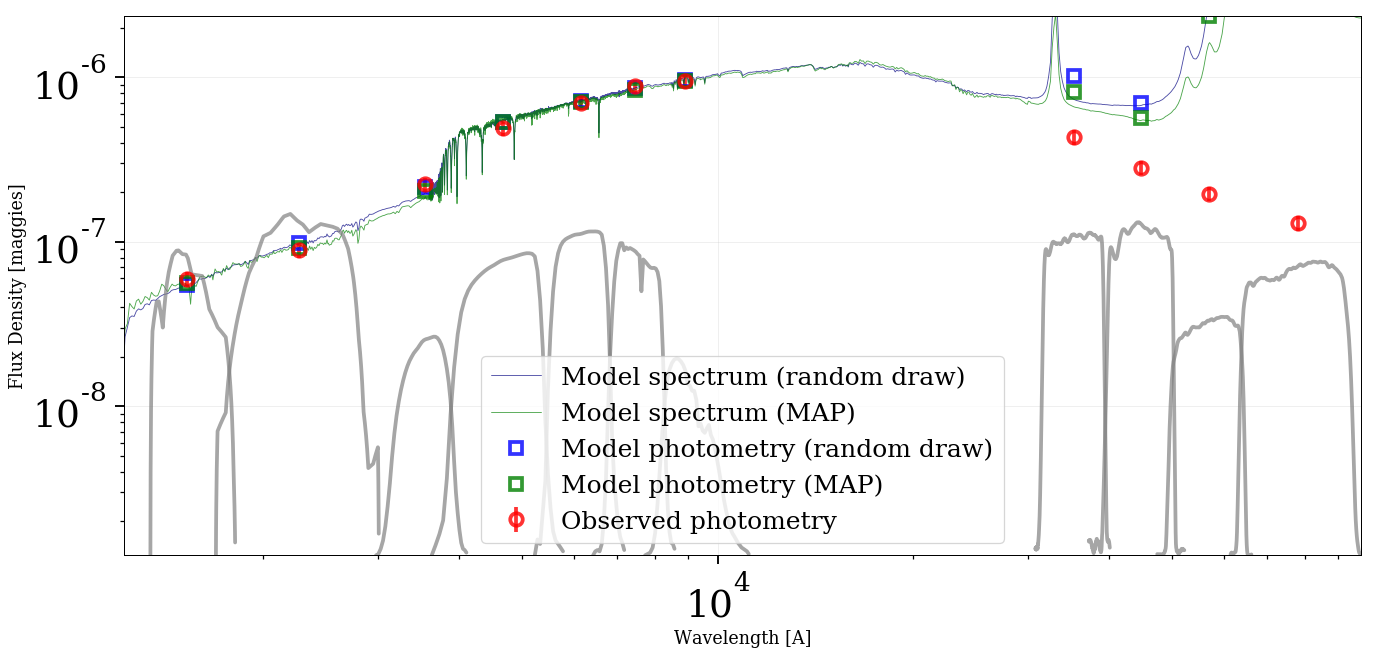

In [34]:
# randomly chosen parameters from chain
randint = np.random.randint
nwalkers, niter = run_params['nwalkers'], run_params['niter']
theta = res['chain'][randint(nwalkers), randint(niter)]

# generate models
# sps = get_sps(res)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()